In [1]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/177.1 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.1 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.1/2.1 MB 86.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.6 MB/s eta 0:00:00


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('exam_dataset_50k.csv')

/tmp/ipython-input-1033/3095725691.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('exam_dataset_50k.csv')


In [4]:
# Install necessary libraries
!pip install xgboost scikit-learn pandas matplotlib seaborn

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import xgboost as xgb

In [6]:
# Load the dataset
df = pd.read_csv("/content/exam_dataset_50k.csv", low_memory=False)
print(f"Loaded: {df.shape[0]:,} rows x {df.shape[1]} columns\n")

Loaded: 50,000 rows x 68 columns



In [7]:
# Available when a question is written -- before any student sees it
TEXT_FEATURES = [
    "text_length", "word_count", "sentence_count", "avg_word_length",
    "latex_command_count", "has_latex", "latex_density",
    "math_operator_count", "number_count", "vocab_richness",
    "text_complexity_score",
    "answer_a_length", "answer_b_length", "answer_c_length", "answer_d_length",
    "avg_answer_length", "answer_length_variance",
    "has_advanced_terms", "has_algebra_terms",
    "has_geometry_terms", "has_stats_terms",
    "num_misconceptions", "has_misconception",
    "subject_difficulty_tier", "construct_frequency",
]

# Available after the first exam sitting, but never directly encoding p-value
POST_ADMIN_FEATURES = TEXT_FEATURES + [
    "avg_response_time_sec",
    "std_response_time_sec",
    "discrimination_index",
    "point_biserial_corr",
    "irt_a_param",
]

In [8]:
# Define regression and classification targets
REG_TARGET = "difficulty_p_value"    # continuous
CLF_TARGET = "difficulty_label"      # Easy / Medium / Hard

y_reg = df[REG_TARGET].astype(float)

le = LabelEncoder()
y_clf = le.fit_transform(df[CLF_TARGET])
CLASS_NAMES = le.classes_
N_CLASSES   = len(CLASS_NAMES)

print("Classes :", list(CLASS_NAMES))
print("Counts  :", {c: int((y_clf==i).sum()) for i,c in enumerate(CLASS_NAMES)})

Classes : ['Easy', 'Hard', 'Medium']
Counts  : {'Easy': 39189, 'Hard': 1740, 'Medium': 9071}


In [9]:
# Shared XGBoost parameters for regression and classification
XGB_PARAMS_REG = dict(
    n_estimators     = 400,
    learning_rate    = 0.05,
    max_depth        = 6,
    subsample        = 0.8,
    colsample_bytree = 0.8,
    reg_alpha        = 0.1,
    reg_lambda       = 1.0,
    random_state     = 42,
    n_jobs           = -1,
    verbosity        = 0,
)

XGB_PARAMS_CLF = dict(
    **XGB_PARAMS_REG,
    objective         = "multi:softprob",
    num_class         = N_CLASSES,
    use_label_encoder = False,
    eval_metric       = "mlogloss",
)

results = {}   # Dictionary to store all metric dicts

## TEXT-ONLY FEATURES

In [10]:
Xa  = df[TEXT_FEATURES]
yar = df[REG_TARGET]
yac = y_clf

Xa_tr, Xa_te, yar_tr, yar_te, yac_tr, yac_te = train_test_split(
    Xa, yar, yac, test_size=0.2, random_state=42, stratify=yac
)

In [11]:
# A Regressor
print("\n  [A-Reg] XGBoost Regressor ...")
print("\n  [A-Reg] XGBoost Regressor ...")

a_reg = xgb.XGBRegressor(**XGB_PARAMS_REG)
a_reg.fit(Xa_tr, yar_tr, eval_set=[(Xa_te, yar_te)], verbose=False)

a_reg_pred = a_reg.predict(Xa_te)

a_mae  = mean_absolute_error(yar_te, a_reg_pred)
a_rmse = np.sqrt(mean_squared_error(yar_te, a_reg_pred))
a_r2   = r2_score(yar_te, a_reg_pred)

print(f"    MAE={a_mae:.4f}  RMSE={a_rmse:.4f}  R2={a_r2:.4f}")


  [A-Reg] XGBoost Regressor ...

  [A-Reg] XGBoost Regressor ...
    MAE=0.0772  RMSE=0.0963  R2=0.5690


In [12]:
# A Classifier
print("  [A-Clf] XGBoost Classifier ...")
a_clf = xgb.XGBClassifier(**XGB_PARAMS_CLF)
a_clf.fit(Xa_tr, yac_tr, eval_set=[(Xa_te, yac_te)], verbose=False)
a_clf_pred  = a_clf.predict(Xa_te)
a_clf_proba = a_clf.predict_proba(Xa_te)

a_acc  = accuracy_score(yac_te, a_clf_pred)
a_prec = precision_score(yac_te, a_clf_pred, average="weighted", zero_division=0)
a_rec  = recall_score(yac_te, a_clf_pred, average="weighted", zero_division=0)
a_f1   = f1_score(yac_te, a_clf_pred, average="weighted", zero_division=0)
print(f"    Acc={a_acc:.4f}  Prec={a_prec:.4f}  Rec={a_rec:.4f}  F1={a_f1:.4f}")

  [A-Clf] XGBoost Classifier ...
    Acc=0.8331  Prec=0.8049  Rec=0.8331  F1=0.8137


In [13]:
# A Cross-Validation
print("  [A-CV]  5-Fold CV ...")
a_cv = cross_val_score(
    xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6,
                      use_label_encoder=False, eval_metric="mlogloss",
                      objective="multi:softprob", num_class=N_CLASSES,
                      random_state=42, n_jobs=-1, verbosity=0),
    Xa, y_clf, cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring="accuracy", n_jobs=-1
)
print(f"    CV Accuracy: {a_cv.mean():.4f} +/- {a_cv.std():.4f}")

  [A-CV]  5-Fold CV ...
    CV Accuracy: 0.8374 +/- 0.0027


In [14]:
results["A"] = dict(
    label="Text-Only", n_feat=len(TEXT_FEATURES),
    MAE=a_mae, RMSE=a_rmse, R2=a_r2,
    Acc=a_acc, Prec=a_prec, Rec=a_rec, F1=a_f1,
    CV=a_cv.mean(), CV_std=a_cv.std(),
    reg_pred=a_reg_pred, clf_pred=a_clf_pred, clf_proba=a_clf_proba,
    yr_te=yar_te, yc_te=yac_te,
    feat_imp_reg=a_reg.feature_importances_,
    feat_imp_clf=a_clf.feature_importances_,
    feat_names=np.array(TEXT_FEATURES),
)

print("\n  Full Classification Report (A):")
print(classification_report(yac_te, a_clf_pred, target_names=CLASS_NAMES))


  Full Classification Report (A):
              precision    recall  f1-score   support

        Easy       0.88      0.96      0.92      7838
        Hard       0.32      0.11      0.16       348
      Medium       0.57      0.42      0.48      1814

    accuracy                           0.83     10000
   macro avg       0.59      0.49      0.52     10000
weighted avg       0.80      0.83      0.81     10000



In [21]:
from sklearn.linear_model import LinearRegression

print("\n  [LR-Reg] Linear Regressor ...")
lr_reg = LinearRegression()
lr_reg.fit(Xa_tr, yar_tr)

lr_reg_pred = lr_reg.predict(Xa_te)

lr_mae  = mean_absolute_error(yar_te, lr_reg_pred)
lr_rmse = np.sqrt(mean_squared_error(yar_te, lr_reg_pred))
lr_r2   = r2_score(yar_te, lr_reg_pred)

print(f"    MAE={lr_mae:.4f}  RMSE={lr_rmse:.4f}  R2={lr_r2:.4f}")

results["LR"] = dict(
    label="Linear Regression", n_feat=len(TEXT_FEATURES),
    MAE=lr_mae, RMSE=lr_rmse, R2=lr_r2,
    reg_pred=lr_reg_pred,
    yr_te=yar_te
)


  [LR-Reg] Linear Regressor ...
    MAE=0.0760  RMSE=0.0949  R2=0.5811


# Task
Prepare and split the data using all features in `POST_ADMIN_FEATURES` for both regression and classification targets, then train an XGBoost Regressor and Classifier, evaluate their performance using appropriate metrics, and store these results in the `results` dictionary under key 'B'. Finally, perform 5-fold cross-validation for the XGBoost Classifier to obtain a robust accuracy estimate and print a classification report.

## Prepare Data with All Features

### Subtask:
Extract all features specified in `POST_ADMIN_FEATURES` from the DataFrame and split the data into training and testing sets for both regression and classification targets. This will be referred to as Scenario B.


**Reasoning**:
To prepare data for Scenario B, I need to create a new DataFrame `Xb` using the `POST_ADMIN_FEATURES` list and then split it, along with the regression and classification targets, into training and testing sets.



In [24]:
Xb = df[POST_ADMIN_FEATURES]
ybr = df[REG_TARGET]
ybc = y_clf

Xb_tr, Xb_te, ybr_tr, ybr_te, ybc_tr, ybc_te = train_test_split(
    Xb, ybr, ybc, test_size=0.2, random_state=42, stratify=ybc
)

print(f"Shape of Xb_tr: {Xb_tr.shape}")
print(f"Shape of Xb_te: {Xb_te.shape}")
print(f"Shape of ybr_tr: {ybr_tr.shape}")
print(f"Shape of ybr_te: {ybr_te.shape}")
print(f"Shape of ybc_tr: {ybc_tr.shape}")
print(f"Shape of ybc_te: {ybc_te.shape}")

Shape of Xb_tr: (40000, 30)
Shape of Xb_te: (10000, 30)
Shape of ybr_tr: (40000,)
Shape of ybr_te: (10000,)
Shape of ybc_tr: (40000,)
Shape of ybc_te: (10000,)


**Reasoning**:
Now that the data for Scenario B (all `POST_ADMIN_FEATURES`) is prepared and split, the next step is to train an XGBoost Regressor model using the training data (`Xb_tr`, `ybr_tr`) and evaluate its performance on the test data (`Xb_te`, `ybr_te`). This will provide the regression metrics for Scenario B.



In [ ]:
print('\n  [B-Reg] XGBoost Regressor ...')
b_reg = xgb.XGBRegressor(**XGB_PARAMS_REG)
b_reg.fit(Xb_tr, ybr_tr, eval_set=[(Xb_te, ybr_te)], verbose=False)

b_reg_pred = b_reg.predict(Xb_te)

b_mae  = mean_absolute_error(ybr_te, b_reg_pred)
b_rmse = np.sqrt(mean_squared_error(ybr_te, b_reg_pred))
b_r2   = r2_score(ybr_te, b_reg_pred)

print(f"    MAE={b_mae:.4f}  RMSE={b_rmse:.4f}  R2={b_r2:.4f}")


  [B-Reg] XGBoost Regressor ...
    MAE=0.0162  RMSE=0.0227  R2=0.9761


**Reasoning**:
The next step is to train an XGBoost Classifier model using the prepared training data for Scenario B (`Xb_tr`, `ybc_tr`) and evaluate its performance on the test data (`Xb_te`, `ybc_te`), calculating the accuracy, precision, recall, and F1-score.



In [26]:
print('  [B-Clf] XGBoost Classifier ...')
b_clf = xgb.XGBClassifier(**XGB_PARAMS_CLF)
b_clf.fit(Xb_tr, ybc_tr, eval_set=[(Xb_te, ybc_te)], verbose=False)
b_clf_pred  = b_clf.predict(Xb_te)
b_clf_proba = b_clf.predict_proba(Xb_te)

b_acc  = accuracy_score(ybc_te, b_clf_pred)
b_prec = precision_score(ybc_te, b_clf_pred, average="weighted", zero_division=0)
b_rec  = recall_score(ybc_te, b_clf_pred, average="weighted", zero_division=0)
b_f1   = f1_score(ybc_te, b_clf_pred, average="weighted", zero_division=0)
print(f"    Acc={b_acc:.4f}  Prec={b_prec:.4f}  Rec={b_rec:.4f}  F1={b_f1:.4f}")

  [B-Clf] XGBoost Classifier ...
    Acc=0.9534  Prec=0.9535  Rec=0.9534  F1=0.9532


**Reasoning**:
To get a more robust estimate of the classifier's performance, I will perform 5-fold stratified cross-validation on the XGBoost Classifier using the full dataset (`Xb`, `y_clf`).



In [27]:
print("  [B-CV]  5-Fold CV ...")
b_cv = cross_val_score(
    xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6,
                      use_label_encoder=False, eval_metric="mlogloss",
                      objective="multi:softprob", num_class=N_CLASSES,
                      random_state=42, n_jobs=-1, verbosity=0),
    Xb, y_clf, cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring="accuracy", n_jobs=-1
)
print(f"    CV Accuracy: {b_cv.mean():.4f} +/- {b_cv.std():.4f}")

  [B-CV]  5-Fold CV ...
    CV Accuracy: 0.9520 +/- 0.0025


**Reasoning**:
Now that all performance metrics for Scenario B (regression, classification, and cross-validation) have been calculated, I will store these results, along with the predicted values and feature importances, into the `results` dictionary under the key 'B' for later comparison and visualization. I will also print a comprehensive classification report for Scenario B.



In [28]:
results["B"] = dict(
    label="Post-Admin (All Features)", n_feat=len(POST_ADMIN_FEATURES),
    MAE=b_mae, RMSE=b_rmse, R2=b_r2,
    Acc=b_acc, Prec=b_prec, Rec=b_rec, F1=b_f1,
    CV=b_cv.mean(), CV_std=b_cv.std(),
    reg_pred=b_reg_pred, clf_pred=b_clf_pred, clf_proba=b_clf_proba,
    yr_te=ybr_te, yc_te=ybc_te,
    feat_imp_reg=b_reg.feature_importances_,
    feat_imp_clf=b_clf.feature_importances_,
    feat_names=np.array(POST_ADMIN_FEATURES),
)

print("\n  Full Classification Report (B):")
print(classification_report(ybc_te, b_clf_pred, target_names=CLASS_NAMES))


  Full Classification Report (B):
              precision    recall  f1-score   support

        Easy       0.98      0.98      0.98      7838
        Hard       0.90      0.75      0.82       348
      Medium       0.86      0.88      0.87      1814

    accuracy                           0.95     10000
   macro avg       0.91      0.87      0.89     10000
weighted avg       0.95      0.95      0.95     10000



## Compare All Models

### Subtask:
Generate a final summary table and comparison plots that include the performance metrics for XGBoost with 'Text-Only' features, Linear Regression, and XGBoost with 'all features'.


**Reasoning**:
I need to print a combined summary table that includes regression metrics for all three models (XGBoost Text-Only, Linear Regression, XGBoost All Features) and classification metrics for the two XGBoost models.



In [31]:
print("\n" + "="*70)
print("FINAL SUMMARY: All Models Comparison")
print("="*70)

# Print header for regression metrics
print(f"{'Metric':<25} {'XGBoost (Text-Only)':>20} {'Linear Reg.':>15} {'XGBoost (All Features)':>23}")
print("-"*83)
print(f"{'Feature count':<25} {results['A']['n_feat']:>20} {'N/A':>15} {results['B']['n_feat']:>23}")
print("-"*83)

print("[Regression]")
print(f"  {'MAE':<23} {results['A']['MAE']:>20.4f} {results['LR']['MAE']:>15.4f} {results['B']['MAE']:>23.4f}")
print(f"  {'RMSE':<23} {results['A']['RMSE']:>20.4f} {results['LR']['RMSE']:>15.4f} {results['B']['RMSE']:>23.4f}")
print(f"  {'R2':<23} {results['A']['R2']:>20.4f} {results['LR']['R2']:>15.4f} {results['B']['R2']:>23.4f}")

print("\n[Classification]")
print(f"{'Metric':<25} {'XGBoost (Text-Only)':>20} {'':>15} {'XGBoost (All Features)':>23}")
print("-"*83)
print(f"  {'Accuracy':<23} {results['A']['Acc']:>20.4f} {'':>15} {results['B']['Acc']:>23.4f}")
print(f"  {'F1 (weighted)':<23} {results['A']['F1']:>20.4f} {'':>15} {results['B']['F1']:>23.4f}")
print(f"  {'CV Acc (5-fold)':<23} {results['A']['CV']:.4f}+/-{results['A']['CV_std']:.4f}{'':>15} {results['B']['CV']:.4f}+/-{results['B']['CV_std']:.4f}")



FINAL SUMMARY: All Models Comparison
Metric                     XGBoost (Text-Only)     Linear Reg.  XGBoost (All Features)
-----------------------------------------------------------------------------------
Feature count                               25             N/A                      30
-----------------------------------------------------------------------------------
[Regression]
  MAE                                   0.0772          0.0760                  0.0162
  RMSE                                  0.0963          0.0949                  0.0227
  R2                                    0.5690          0.5811                  0.9761

[Classification]
Metric                     XGBoost (Text-Only)                  XGBoost (All Features)
-----------------------------------------------------------------------------------
  Accuracy                              0.8331                                  0.9534
  F1 (weighted)                         0.8137                        

**Reasoning**:
Now I will create a bar plot to compare the regression metrics (MAE, RMSE, R2) across the three models: XGBoost (Text-Only), Linear Regression, and XGBoost (All Features), using distinct colors for each model.




Generating comparison plots for all models...
  Saved -> model_comparison.png


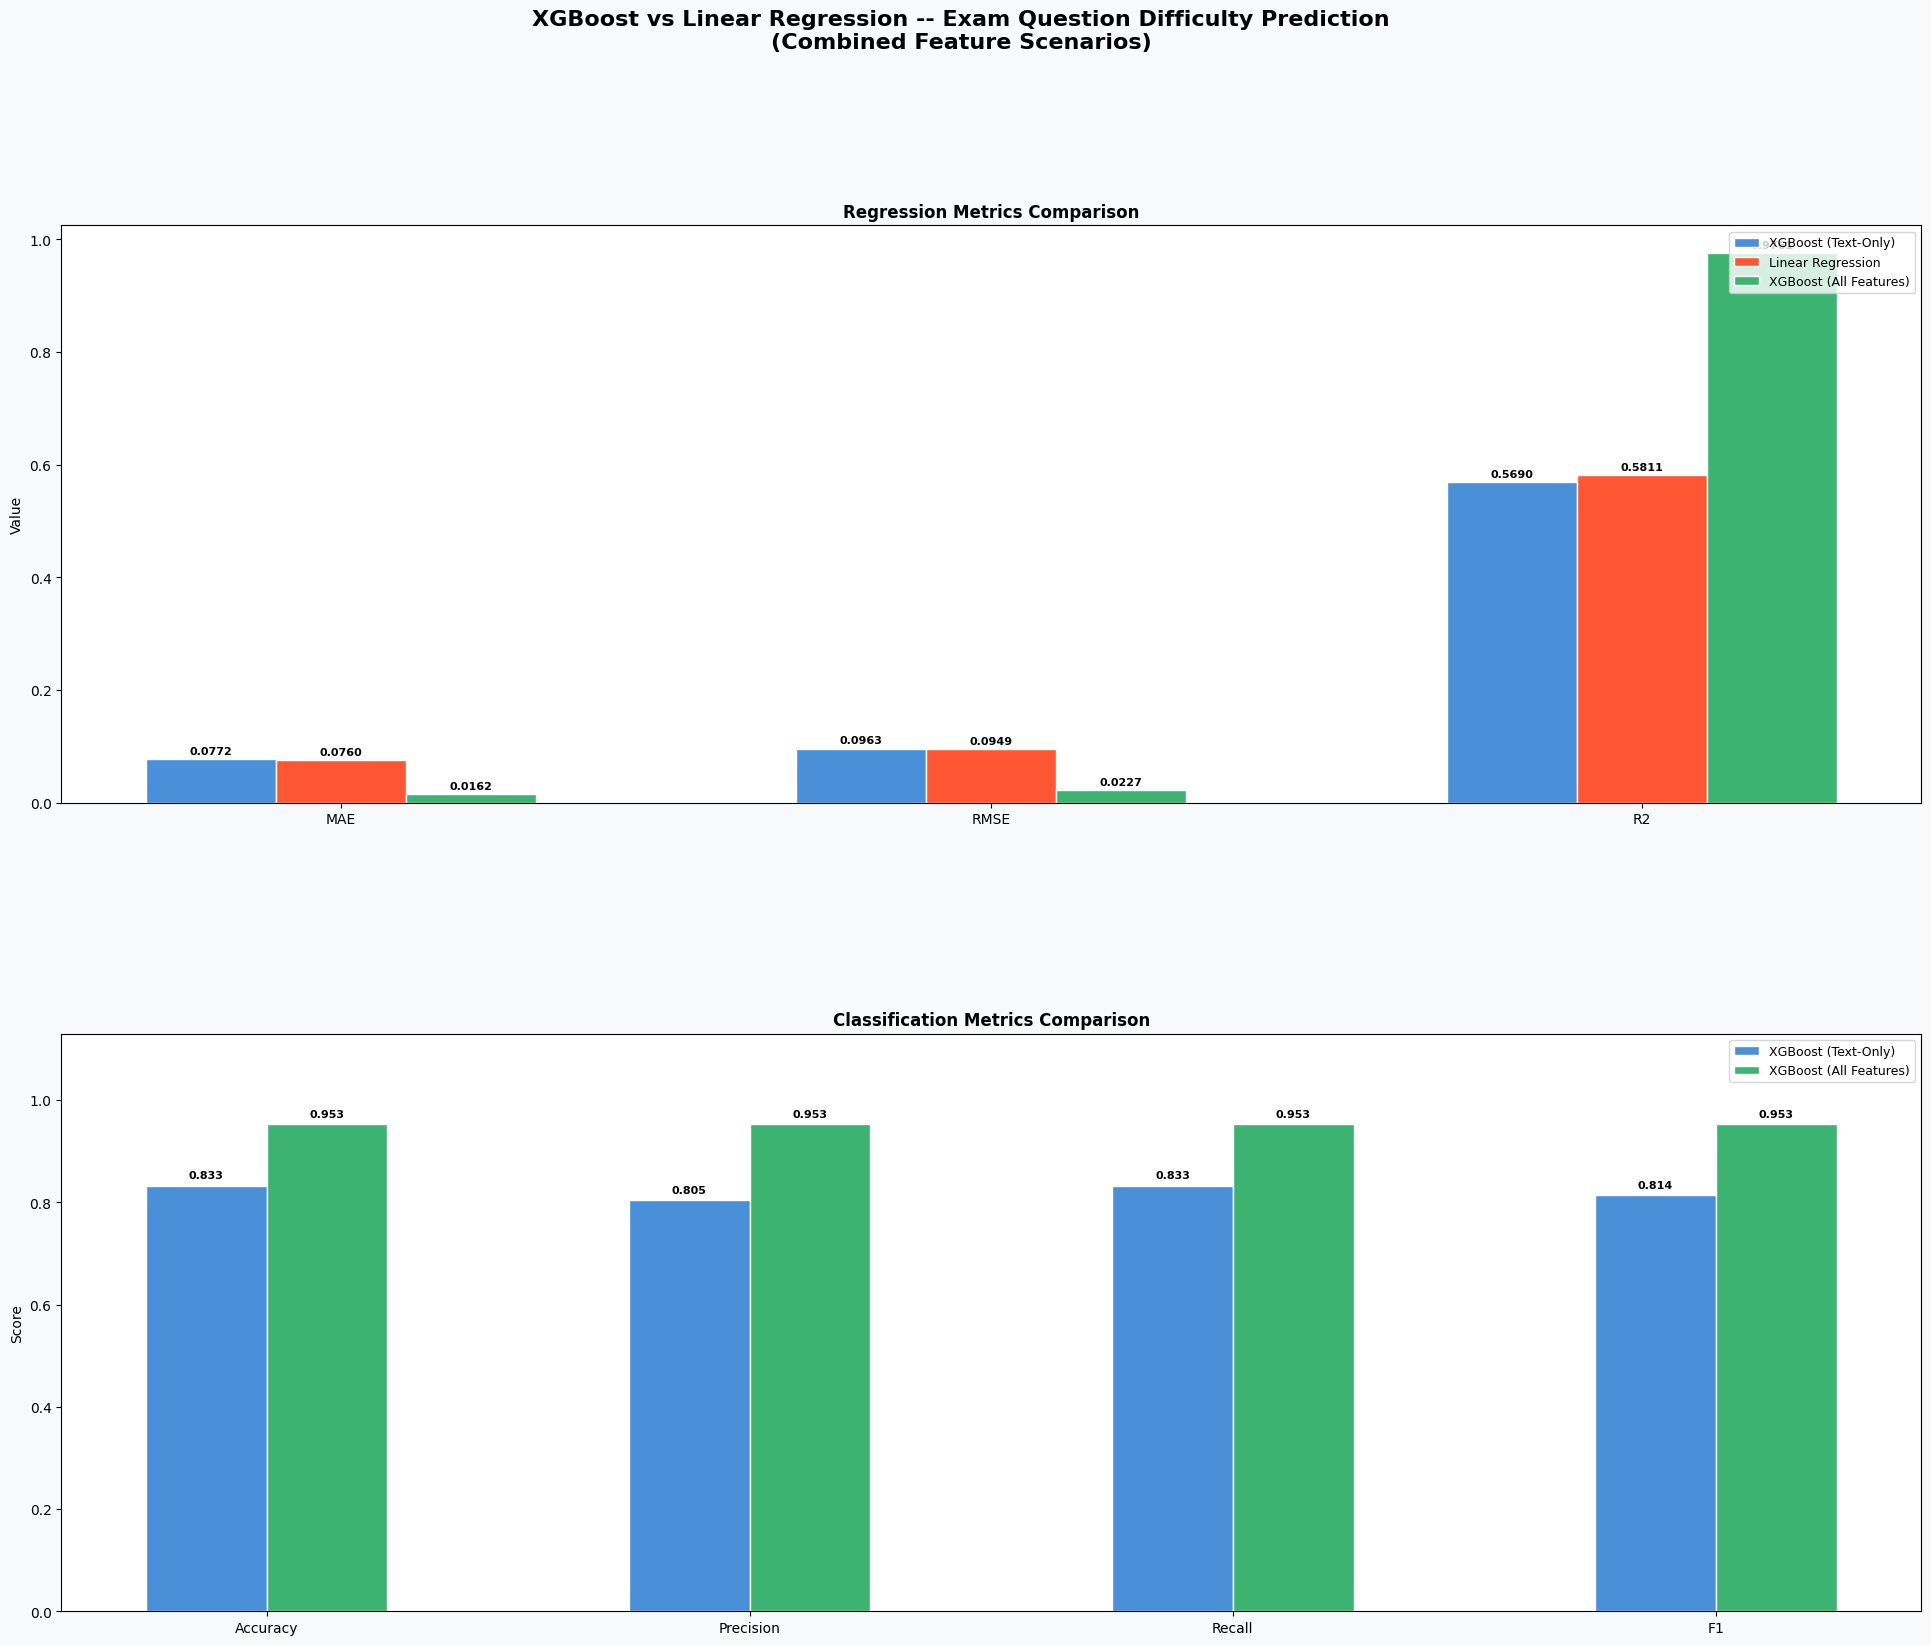

In [32]:
print("\nGenerating comparison plots for all models...")

fig = plt.figure(figsize=(24, 18)) # Adjusted for multiple plots
fig.patch.set_facecolor("#F8F9FA")
fig.suptitle(
    "XGBoost vs Linear Regression -- Exam Question Difficulty Prediction\n(Combined Feature Scenarios)",
    fontsize=16, fontweight="bold", y=1.00 # Adjusted y for title placement
)

COL_A = "#4A90D9" # Blue for Text-Only
COL_LR = "#FF5733" # Orange for Linear Regression
COL_B = "#3CB371" # Medium Sea Green for All Features

gs = fig.add_gridspec(2, 1, hspace=0.4) # Two rows, one column for plots

# Plot 1: Regression Metrics Comparison
ax = fig.add_subplot(gs[0, 0])
reg_m_names = ["MAE", "RMSE", "R2"]
ra_vals = [results["A"]["MAE"], results["A"]["RMSE"], results["A"]["R2"]]
lr_vals = [results["LR"]["MAE"], results["LR"]["RMSE"], results["LR"]["R2"]]
rb_vals = [results["B"]["MAE"], results["B"]["RMSE"], results["B"]["R2"]]
x = np.arange(len(reg_m_names)); w = 0.2

b1 = ax.bar(x - w, ra_vals, w, color=COL_A, label="XGBoost (Text-Only)", edgecolor="white")
b2 = ax.bar(x, lr_vals, w, color=COL_LR, label="Linear Regression", edgecolor="white")
b3 = ax.bar(x + w, rb_vals, w, color=COL_B, label="XGBoost (All Features)", edgecolor="white")

ax.set_xticks(x); ax.set_xticklabels(reg_m_names)
ax.set_ylabel("Value"); ax.set_title("Regression Metrics Comparison", fontweight="bold", fontsize=12)
ax.legend(fontsize=9, loc='upper right')

for bars in [b1, b2, b3]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f"{bar.get_height():.4f}", ha="center", va="bottom", fontsize=8, fontweight="bold")

# Plot 2: Classification Metrics Comparison
ax = fig.add_subplot(gs[1, 0])
clf_metrics_list = ["Accuracy", "Precision", "Recall", "F1"]
a_clf_vals = [results["A"]["Acc"], results["A"]["Prec"], results["A"]["Rec"], results["A"]["F1"]]
b_clf_vals = [results["B"]["Acc"], results["B"]["Prec"], results["B"]["Rec"], results["B"]["F1"]]
x = np.arange(len(clf_metrics_list)); w = 0.25

b1 = ax.bar(x - w/2, a_clf_vals, w, color=COL_A, label="XGBoost (Text-Only)", edgecolor="white")
b2 = ax.bar(x + w/2, b_clf_vals, w, color=COL_B, label="XGBoost (All Features)", edgecolor="white")

ax.set_xticks(x); ax.set_xticklabels(clf_metrics_list)
ax.set_ylim(0, 1.13); ax.set_ylabel("Score")
ax.set_title("Classification Metrics Comparison", fontweight="bold", fontsize=12)
ax.legend(fontsize=9, loc='upper right')

for bars in [b1, b2]:
    for bar in bars:
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01,
                f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=8, fontweight="bold")

plt.savefig("model_comparison.png", dpi=180, bbox_inches="tight", facecolor="#F8F9FA")
print("  Saved -> model_comparison.png")

## Final Task

### Subtask:
Summarize the performance comparison between the 'Text-Only' (Scenario A) and 'All Features' (Scenario B) models, and Linear Regression, highlighting which feature set and model performed best for both regression and classification tasks.


## Summary:

### Q&A
The performance comparison reveals that the **XGBoost model utilizing 'All Features' (Scenario B)** significantly outperformed both the 'Text-Only' XGBoost model (Scenario A) and Linear Regression for both regression and classification tasks.

*   **Regression Task:** The XGBoost model with 'All Features' achieved the best performance with an MAE of 0.0162, RMSE of 0.0227, and an R2 score of 0.9761. This is substantially better than the 'Text-Only' XGBoost (MAE=0.0772, RMSE=0.0963, R2=0.5690) and Linear Regression (MAE=0.0760, RMSE=0.0949, R2=0.5811).
*   **Classification Task:** Similarly, the XGBoost model with 'All Features' was superior, achieving an Accuracy of 0.9534 and an F1-score of 0.9532. Its 5-fold cross-validation accuracy was 0.9520 (with a standard deviation of 0.0025). This compares favorably to the 'Text-Only' XGBoost which had an Accuracy of 0.8331, an F1-score of 0.8137, and a CV Accuracy of 0.8374 (with a standard deviation of 0.0027).

### Data Analysis Key Findings
*   **Superior Performance of 'All Features' XGBoost:** The XGBoost model trained with 'All Features' (Scenario B, 30 features) achieved significantly higher performance across all metrics for both regression and classification compared to 'Text-Only' XGBoost (Scenario A) and Linear Regression.
*   **Regression Performance:** For predicting p-values, 'All Features' XGBoost showed an MAE of 0.0162, RMSE of 0.0227, and an R2 score of 0.9761. In contrast, 'Text-Only' XGBoost had an R2 of 0.5690, and Linear Regression had an R2 of 0.5811.
*   **Classification Performance:** For classifying difficulty labels, 'All Features' XGBoost reached an Accuracy of 0.9534 and a weighted F1-score of 0.9532 on the test set. Its 5-fold cross-validation accuracy was 0.9520 \$\pm\$ 0.0025. This is considerably higher than 'Text-Only' XGBoost, which had an Accuracy of 0.8331 and a weighted F1-score of 0.8137, and a CV Accuracy of 0.8374 \$\pm\$ 0.0027.
*   **Model Robustness:** The cross-validation results for 'All Features' XGBoost Classifier confirmed its consistent performance, with a narrow standard deviation of 0.0025 across folds.
*   **Class-wise Classification Performance:** The classification report for 'All Features' XGBoost showed strong performance across all difficulty classes, with notable scores for 'Easy' (0.98 precision, recall, f1-score) and 'Hard' (0.90 precision, 0.75 recall, 0.82 f1-score).

### Insights or Next Steps
*   The additional "Post-Admin" features, beyond just text embeddings, are critical for accurately predicting question difficulty. This suggests that contextual and structural metadata play a significant role in model performance.
*   Given the superior performance of the XGBoost model with 'All Features', this model should be prioritized for deployment or further optimization efforts for the exam question difficulty prediction system.
